This notebook contains the analysis of the relative sales figures by genre.

In [1]:
%matplotlib inline
import numpy as np # imports a fast numerical programming library
import scipy as sp # imports stats functions, amongst other things
import matplotlib as mpl # this actually imports matplotlib
import matplotlib.cm as cm # allows us easy access to colormaps
import matplotlib.pyplot as plt # sets up plotting under plt
import pandas as pd # lets us handle data as dataframes
from scipy.optimize import curve_fit
#import pickle

# sets up pandas table display
pd.set_option('display.width', 500)
pd.set_option('display.max_columns', 100)
pd.set_option('display.notebook_repr_html', True)

import seaborn as sns # sets up styles and gives us more plotting options

In [138]:
# Read in our data
data = pd.read_csv('data/games_sales_clean.csv')
# Change the data type of Year of Release to int
data['Year_of_Release'] = data['Year_of_Release'].apply(lambda x: int(x))
data.head()

,Name,Platform,Year_of_Release,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales,Global_Sales
0,Wii Sports,Wii,2006,Sports,Nintendo,41.36,28.96,3.77,8.45,82.53
1,Super Mario Bros.,NES,1985,Platform,Nintendo,29.08,3.58,6.81,0.77,40.24
2,Mario Kart Wii,Wii,2008,Racing,Nintendo,15.68,12.76,3.79,3.29,35.52
3,Wii Sports Resort,Wii,2009,Sports,Nintendo,15.61,10.93,3.28,2.95,32.77
4,Pokemon Red/Pokemon Blue,GB,1996,Role-Playing,Nintendo,11.27,8.89,10.22,1.00,31.37


We first look at the total sales figures for each region, so we can later calculate the relative market share of the different genres.

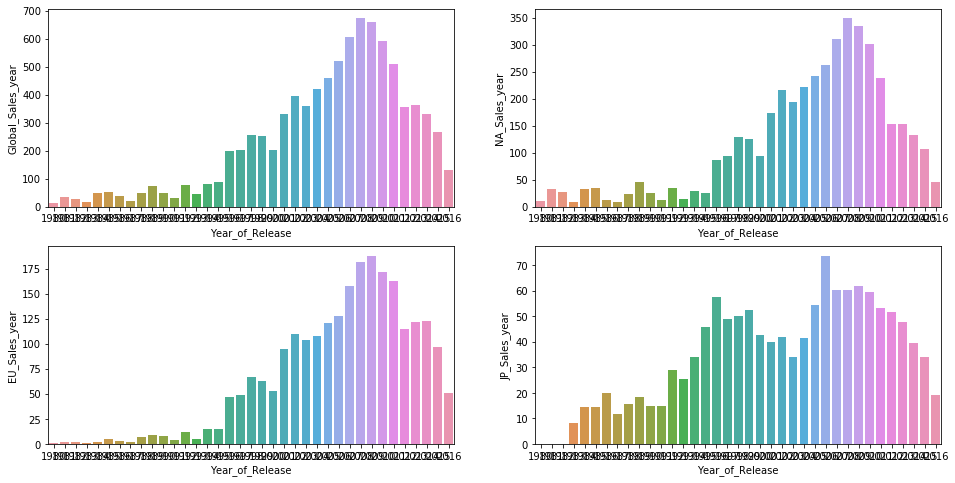

In [139]:
# sales figures over the years - Inflation not taken into account
sales_data = data.groupby(['Year_of_Release'])['Global_Sales'].agg(Global_Sales_year='sum')
NA_sales_data = data.groupby(['Year_of_Release'])['NA_Sales'].agg(NA_Sales_year='sum')
EU_sales_data = data.groupby(['Year_of_Release'])['EU_Sales'].agg(EU_Sales_year='sum')
JP_sales_data = data.groupby(['Year_of_Release'])['JP_Sales'].agg(JP_Sales_year='sum')

plt.figure(figsize=(16,8))
plt.subplot(2,2,1)
sns.barplot(x=sales_data.index, y=sales_data['Global_Sales_year'])
plt.subplot(2,2,2)
sns.barplot(x=NA_sales_data.index, y=NA_sales_data['NA_Sales_year'])
plt.subplot(2,2,3)
sns.barplot(x=EU_sales_data.index, y=EU_sales_data['EU_Sales_year'])
plt.subplot(2,2,4)
sns.barplot(x=JP_sales_data.index, y=JP_sales_data['JP_Sales_year'])
plt.show()

We now visualize the data separated for each genre.

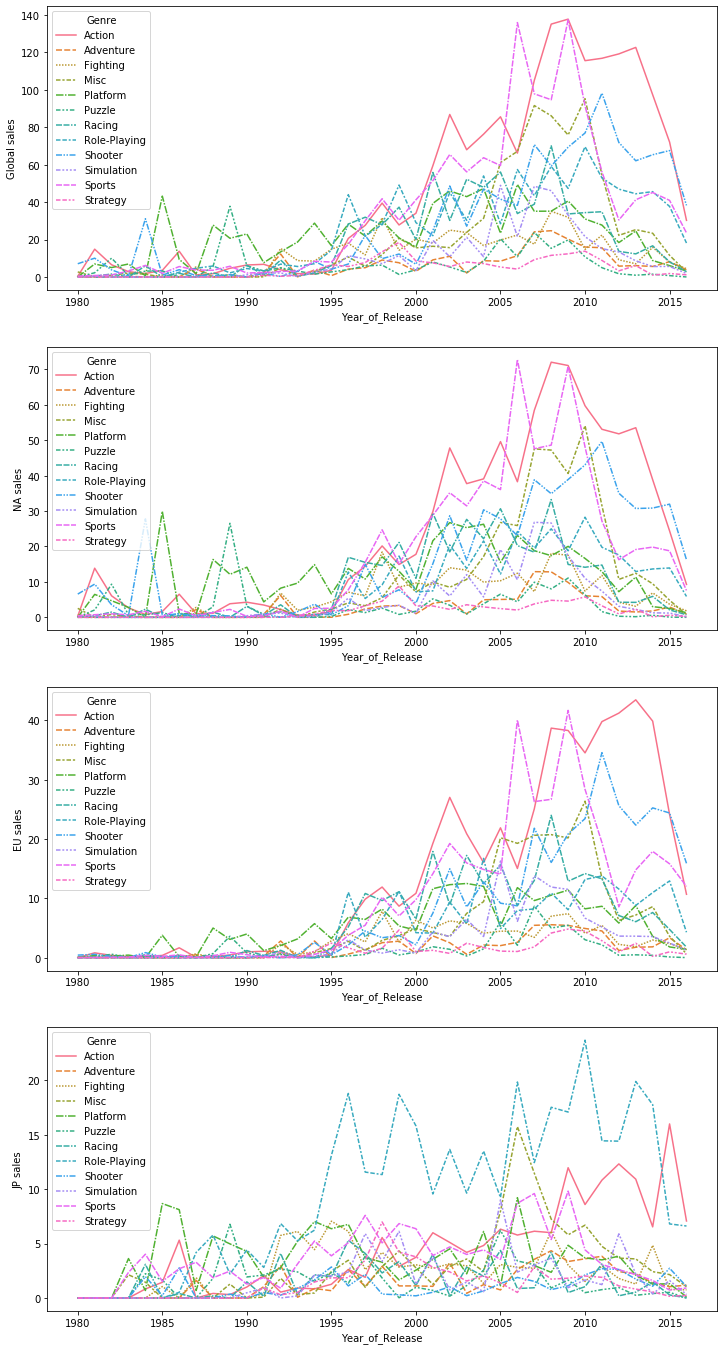

In [140]:
# sales figures per year and genre (Global, NA, EU and JP)
genre_data = data.groupby(['Year_of_Release','Genre'])['Global_Sales'].agg(Global_Sales_year='sum')
NA_genre_data = data.groupby(['Year_of_Release','Genre'])['NA_Sales'].agg(NA_Sales_year='sum')
EU_genre_data = data.groupby(['Year_of_Release','Genre'])['EU_Sales'].agg(EU_Sales_year='sum')
JP_genre_data = data.groupby(['Year_of_Release','Genre'])['JP_Sales'].agg(JP_Sales_year='sum')

#reshapes the table so the second index becomes the columns instead
genre_data = genre_data.reset_index().pivot(columns='Genre',index='Year_of_Release',values='Global_Sales_year').fillna(0)
NA_genre_data = NA_genre_data.reset_index().pivot(columns='Genre',index='Year_of_Release',values='NA_Sales_year').fillna(0)
EU_genre_data = EU_genre_data.reset_index().pivot(columns='Genre',index='Year_of_Release',values='EU_Sales_year').fillna(0)
JP_genre_data = JP_genre_data.reset_index().pivot(columns='Genre',index='Year_of_Release',values='JP_Sales_year').fillna(0)

plt.figure(figsize=(12,6*4))
plt.subplot(4,1,1)
sns.lineplot(data=genre_data)
plt.ylabel('Global sales')
plt.subplot(4,1,2)
sns.lineplot(data=NA_genre_data)
plt.ylabel('NA sales')
plt.subplot(4,1,3)
sns.lineplot(data=EU_genre_data)
plt.ylabel('EU sales')
plt.subplot(4,1,4)
sns.lineplot(data=JP_genre_data)
plt.ylabel('JP sales')
plt.show()

To better compare the data over the years we take a look at the realtive sales, i.e. the market share of every genre on the total sales per year.

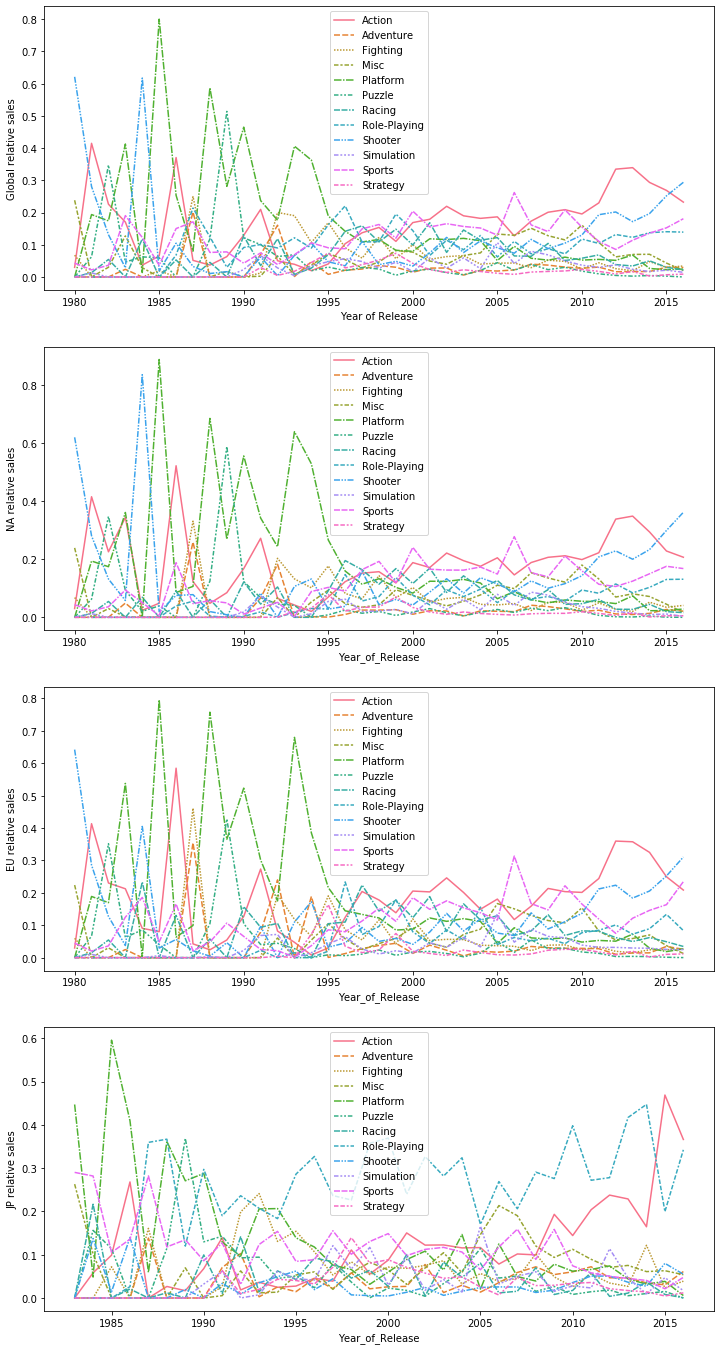

In [178]:
# relative sales figures per genre and year (Global, NA, EU, JP)
genre_rel = pd.concat([genre_data, sales_data], axis=1,sort=False)
genre_rel = genre_rel.div(genre_rel['Global_Sales_year'], axis=0).drop(columns='Global_Sales_year')
NA_genre_rel = pd.concat([NA_genre_data, NA_sales_data], axis=1,sort=False)
NA_genre_rel = NA_genre_rel.div(NA_genre_rel['NA_Sales_year'], axis=0).drop(columns='NA_Sales_year')
EU_genre_rel = pd.concat([EU_genre_data, EU_sales_data], axis=1,sort=False)
EU_genre_rel = EU_genre_rel.div(EU_genre_rel['EU_Sales_year'], axis=0).drop(columns='EU_Sales_year')
JP_genre_rel = pd.concat([JP_genre_data, JP_sales_data], axis=1,sort=False)
JP_genre_rel = JP_genre_rel.div(JP_genre_rel['JP_Sales_year'], axis=0).drop(columns='JP_Sales_year')

# plot the results 
plt.figure(figsize=(12,6*4))

plt.subplot(4,1,1)
sns.lineplot(data=genre_rel)
plt.ylabel('Global relative sales')
plt.xlabel('Year of Release')
plt.subplot(4,1,2)
sns.lineplot(data=NA_genre_rel)
plt.ylabel('NA relative sales')
plt.subplot(4,1,3)
sns.lineplot(data=EU_genre_rel)
plt.ylabel('EU relative sales')
plt.subplot(4,1,4)
sns.lineplot(data=JP_genre_rel)
plt.ylabel('JP relative sales')
plt.show()
# plt.savefig('sales_genre.png')

Obviously the landscape of videogame genres changed drastically in the years '90. For regression and further analysis we limit ourselfs to the more recent years, i.e. the years 2000-2016.

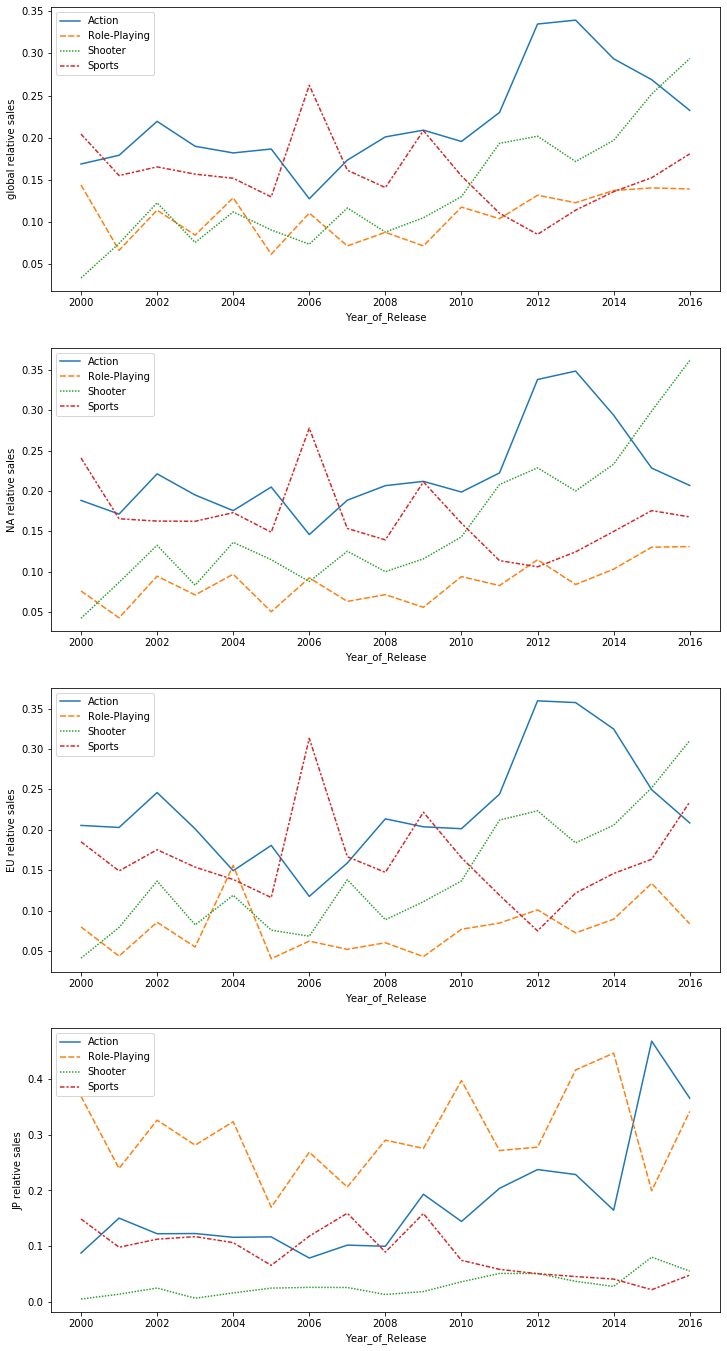

In [172]:
# drop all rows with release date before 2000 (Global, NA, EU, JP)
indizes = genre_rel[genre_rel.index<2000].index
genre_rel.drop(indizes, inplace=True)
indizes = NA_genre_rel[NA_genre_rel.index<2000].index
NA_genre_rel.drop(indizes, inplace=True)
indizes = EU_genre_rel[EU_genre_rel.index<2000].index
EU_genre_rel.drop(indizes, inplace=True)
indizes = JP_genre_rel[JP_genre_rel.index<2000].index
JP_genre_rel.drop(indizes, inplace=True)

# plot the results
plt.figure(figsize=(12,6*4))

plt.subplot(4,1,1)
sns.lineplot(data=genre_rel)
plt.ylabel('global relative sales')
plt.legend(loc=2)
plt.subplot(4,1,2)
sns.lineplot(data=NA_genre_rel)
plt.ylabel('NA relative sales')
plt.legend(loc=2)
plt.subplot(4,1,3)
sns.lineplot(data=EU_genre_rel)
plt.ylabel('EU relative sales')
plt.legend(loc=2)
plt.subplot(4,1,4)
sns.lineplot(data=JP_genre_rel)
plt.ylabel('JP relative sales')
plt.legend(loc=2)
#plt.show()
plt.savefig('rel_genre.pdf')

We now have a look at the data in those last 16 years. For the regression we focus only on the top 4 Genres in 2016.

In [143]:
# # Prepare data so the sales are relative to the figures of the whole year
# data_rel = data.merge(sales_data, on=['Year_of_Release'])
# data_rel[['NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales']] = data_rel[['NA_Sales','EU_Sales','JP_Sales','Other_Sales','Global_Sales']].div(data_rel['Global_Sales_year'], axis=0)

# # drop all rows with release date before 2000
# indizes = data_rel[data_rel['Year_of_Release']<2000].index
# data_rel.drop(indizes, inplace=True)


# plt.figure(figsize=(16,8))
# plt.ylabel('relative sales')
# plt.xlabel('year of release')
# sns.scatterplot(x=data_rel['Year_of_Release'], y=data_rel['Global_Sales'], hue=data_rel['Genre'])

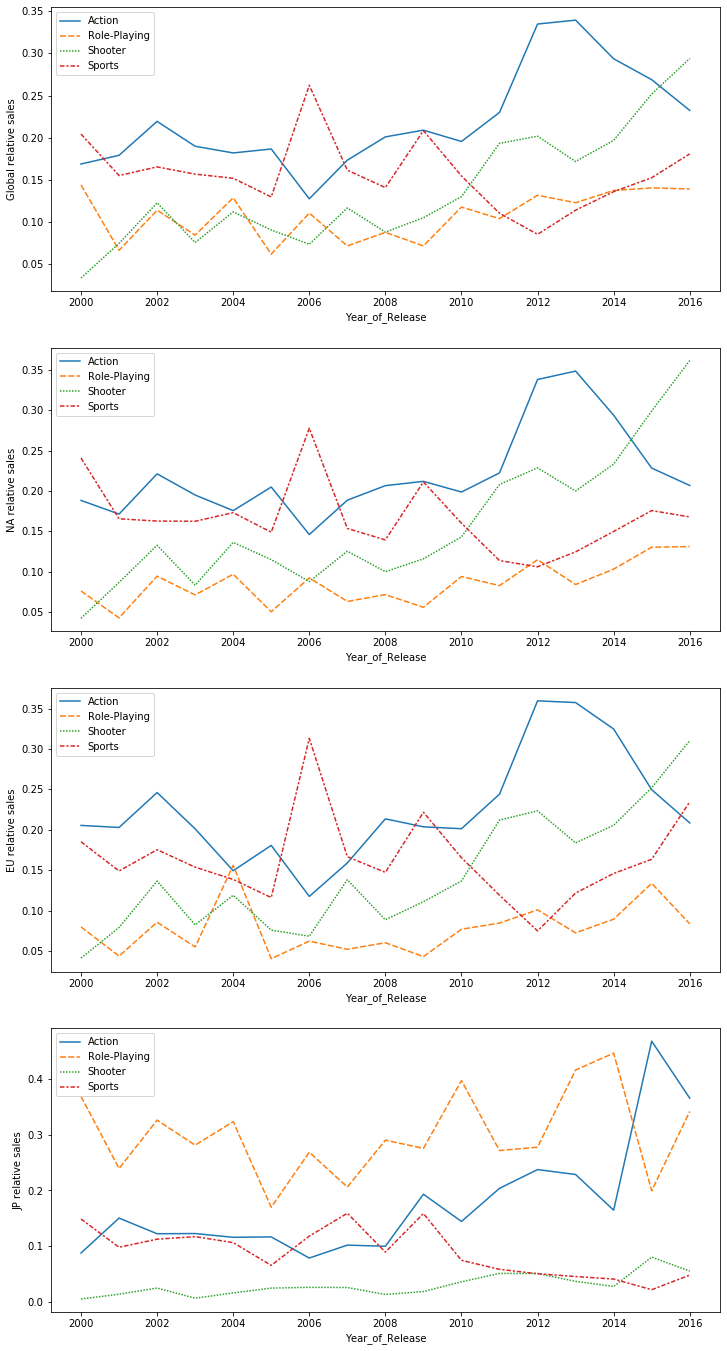

In [145]:
# drop all columns except four most successful genres
genre_rel.drop(genre_rel.columns.difference(['Action','Role-Playing','Shooter','Sports']), 1, inplace=True)
NA_genre_rel.drop(NA_genre_rel.columns.difference(['Action','Role-Playing','Shooter','Sports']), 1, inplace=True)
EU_genre_rel.drop(EU_genre_rel.columns.difference(['Action','Role-Playing','Shooter','Sports']), 1, inplace=True)
JP_genre_rel.drop(JP_genre_rel.columns.difference(['Action','Role-Playing','Shooter','Sports']), 1, inplace=True)

# Put all the data in one array
regions = ['Global', 'NA', 'EU', 'JP']
genre_rel_arr = [genre_rel, NA_genre_rel, EU_genre_rel, JP_genre_rel]


# plot the results
plt.figure(figsize=(12,6*4))

for j, reg in enumerate(regions):
    plt.subplot(4,1,j+1)
    sns.lineplot(data=genre_rel_arr[j])
    plt.ylabel('%s relative sales' %(reg))
    plt.legend(loc=2)
plt.show()

##################    Regression    ####################

In the following we will try to do a polynomial regression (1st, 2nd and 3rd degree) on the development of the relative sales figures for every genre and region. We use Gradient descent, defining the necessary functions:

In [146]:
# Definition of fit functions
def lin_fun(theta, x):
    
    return theta[1]*x + theta[0]

def poly2_fun(theta, x):
    
    return theta[2]*x**2 + theta[1]*x + theta[0]

def poly3_fun(theta, x):
    
    return theta[3]*x**3 + theta[2]*x**2 + theta[1]*x + theta[0]

# Quadratic loss function
def quad_loss(theta, x, y, h):
    
    m = len(x)
    l = 0
    
    for i in range(0,m):
        l += (h(theta,x[i])-y[i])**2/(2*m)
    
    return l

# Gradient of loss function
def grad_quad_loss(theta, x, y, h):
    
    m = len(x)
    G = np.zeros(len(theta))
    
    for i in range(0,m):
        for j in range(len(theta)):
            G[j] += (h(theta,x[i])-y[i])/m * x[i]**j
    
    return G

# Gradient descent algorithm
def gradient_descent(theta,x,y,H,alpha,eps):
       
    loss_history = []
    theta_history = []
    
    while np.linalg.norm(grad_quad_loss(theta, x, y, H))>=eps:
        theta_history.append(theta)
        loss_history.append(quad_loss(theta,x,y,H))
        theta = theta - alpha*grad_quad_loss(theta, x, y, H)
        #print(quad_loss(theta,x,y,H), np.linalg.norm(alpha*grad_quad_loss(theta, x, y, H)))
        
    return theta, loss_history, theta_history

Selecting the relevant data before the regression.

In [147]:
genres = ['Action','Role-Playing','Shooter','Sports']
col = ['blue', 'orange', 'green', 'red']

# contains the year of release as x-values
# In order for the gradiend descent algorithm to work properly we substract 2000 here.
x = np.array(genre_rel.index.to_list())-2000

# contains the sales figures as y-values for all the regions
y = np.empty((len(regions), len(genres), len(x)))
for i,gen in enumerate(genres):
    y[0][i] = genre_rel[gen].to_list()
    y[1][i] = NA_genre_rel[gen].to_list()
    y[2][i] = EU_genre_rel[gen].to_list()
    y[3][i] = JP_genre_rel[gen].to_list()

Linear Regression - outputting the parameters with corresponding loss.

Global
Action [0.15593935 0.00794022] [0.0008599289216559073]
Role-Playing [0.08908489 0.00236445] [0.00031495943726314205]
Shooter [0.03897263 0.0122845 ] [0.0005136970559919709]
Sports [ 0.17841474 -0.00266436] [0.0007146952326133386]
NA
Action [0.16972135 0.00632114] [0.000974323075351767]
Role-Playing [0.05950379 0.00326749] [0.0001806425170686994]
Shooter [0.04164362 0.01463841] [0.0007945937901310354]
Sports [ 0.19272325 -0.0032598 ] [0.0007470410247510122]
EU
Action [0.16910293 0.00698358] [0.0015768429750292992]
Role-Playing [0.06379506 0.0017228 ] [0.0004227368370745518]
Shooter [0.04248144 0.01280559] [0.0006682865162364504]
Sports [ 0.17062334 -0.00080264] [0.001369073653656121]
JP
Action [0.05463074 0.01523993] [0.0023010376575186564]
Role-Playing [0.27384321 0.00331471] [0.002678053805333715]
Shooter [0.00486663 0.0031116 ] [6.909870210974396e-05]
Sports [ 0.13711583 -0.00604443] [0.0004330299507971106]


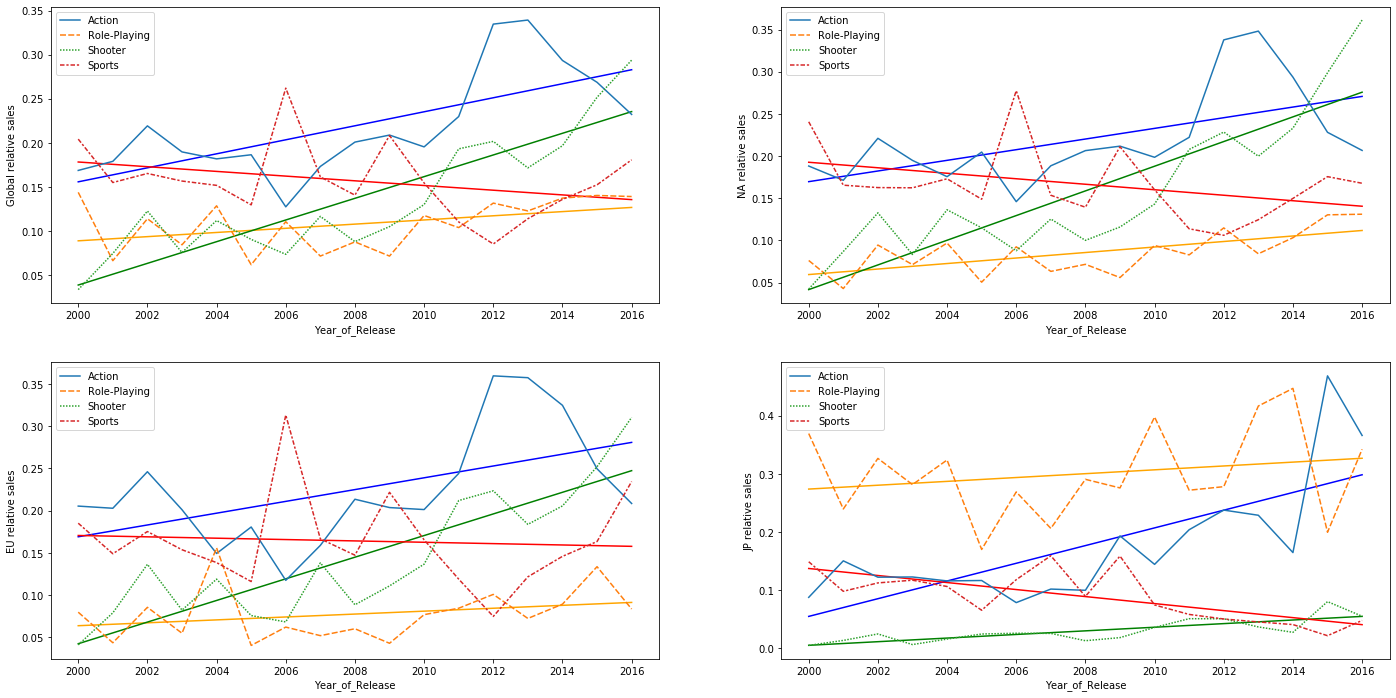

In [38]:
theta_lin = np.empty((len(regions),len(genres), 2))
loss_lin = np.empty((len(regions),len(genres)))

# Determine the parameters and output the results    
plt.figure(figsize=(12*2,12))

# Loop over the regions - Global, NA, EU, JP
for j, reg in enumerate(regions):
    
    print(reg)
    plt.subplot(2,2,j+1)

    # Loop over the different genres
    for i,gen in enumerate(genres):

        # Initialize theta0
        theta0 = np.zeros(2)

        # Determine parameters using Gradient descent
        theta_final, loss_history, theta_history = gradient_descent(theta0,x,y[j][i],lin_fun,1e-3, 1e-6)
        theta_lin[j][i] = theta_final
        loss_lin[j][i] = loss_history[len(loss_history)-1]
        print(gen, theta_final, loss_history[-1:])

#             fig,ax = plt.subplots(num=2)

#             ax.set_ylabel('l(Theta)')
#             ax.set_xlabel('Iterations')
#             _=ax.plot(range(len(loss_history))[1:],loss_history[1:],'b.')
#             plt.show()

        plt.plot(x+2000, lin_fun(theta_final, x), color=col[i])

    sns.lineplot(data=genre_rel_arr[j])
    plt.ylabel('%s relative sales' %(reg))
plt.show()


2nd degree Polynomial regression:

Global
[0.17383598 0.00078159 0.00044741] 0.0008142687918106659
[ 0.1157979  -0.00832074  0.00066782] 0.00021324539513245118
[ 0.07654811 -0.00274568  0.00093939] 0.00031245919773326456
[ 1.84912332e-01 -5.26338099e-03  1.62438635e-04] 0.00070867222026805
NA
[1.74559280e-01 4.38598287e-03 1.20947187e-04] 0.000970982678176168
[ 0.0763569  -0.00347374  0.00042133] 0.00014015084346986794
[ 0.09393561 -0.00627837  0.0013073 ] 0.0004048790835808743
[ 0.20431657 -0.00789711  0.00028983] 0.0007278760720851402
EU
[ 0.19486306 -0.00332045  0.000644  ] 0.0014822550172115233
[ 0.07851075 -0.00416346  0.00036789] 0.00039186270098733386
[ 0.08220523 -0.00308391  0.00099309] 0.00044338247744742944
[ 0.17811942 -0.00380106  0.0001874 ] 0.0013610585023487733
JP
[ 0.13797371 -0.01809725  0.00208357] 0.0013111375094854777
[ 0.30785221 -0.01028887  0.00085022] 0.0025132007359112275
[0.01101837 0.00065092 0.00015379] 6.369944935183634e-05
[ 0.11877429  0.0012922  -0.00045854] 0.000385110582549147


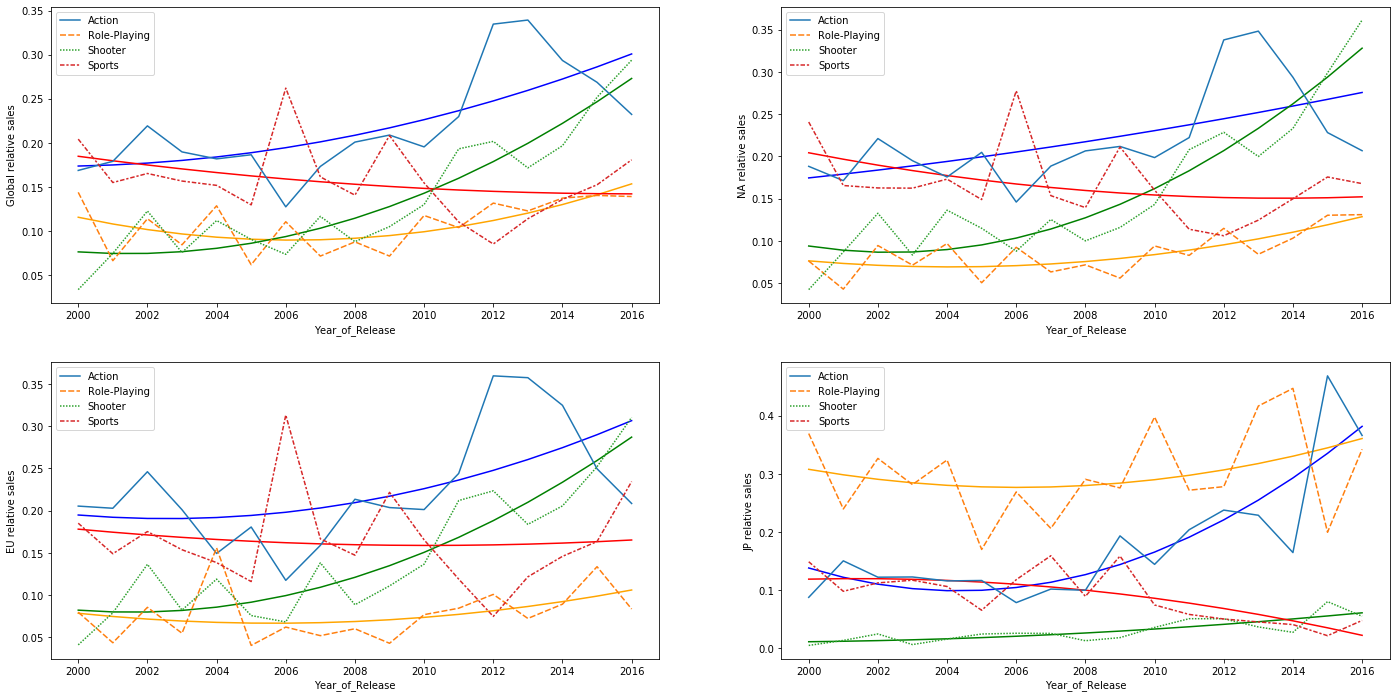

In [39]:
theta_pol = np.empty((len(regions),len(genres), 3))
loss_pol = np.empty((len(regions),len(genres)))

# Determine the parameters and output the results    
plt.figure(figsize=(12*2,12))

# Loop over the regions - Global, NA, EU, JP
for j, reg in enumerate(regions):
    
    print(reg)
    plt.subplot(2,2,j+1)

    # Loop over the different genres
    for i,gen in enumerate(genres):

        # Initialize theta0
        theta0 = np.zeros(3)

        # Determine parameters using Gradient descent
        theta_final, loss_history, theta_history = gradient_descent(theta0,x,y[j][i],poly2_fun,1e-4, 1e-6)
        theta_pol[j][i] = theta_final
        loss_pol[j][i] = loss_history[len(loss_history)-1]
        
        print(theta_final, loss_history[len(loss_history)-1])

        plt.plot(x+2000, poly2_fun(theta_final, x), color=col[i])

    sns.lineplot(data=genre_rel_arr[j])
    plt.ylabel('%s relative sales' %(reg))
plt.show()


(3rd degree Polynomial regression: Doesn't work right)

In [148]:
# # Determine the parameters and output the results   
# plt.figure()

# for i,gen in enumerate(genres):
    
#     # Initialize theta0
#     theta0 = np.zeros(4)
#     theta0[0] += 0.1

#     # Determine parameters using Gradient descent
#     theta_final, loss_history, theta_history = gradient_descent(theta0,x,y[0][i],poly3_fun,7e-7, 5e-9)
#     print(theta_final, loss_history[-1:])
    
# #     fig,ax = plt.subplots(num=2)

# #     ax.set_ylabel('l(Theta)')
# #     ax.set_xlabel('Iterations')
# #     _=ax.plot(range(len(loss_history))[1:],loss_history[1:],'b.')
# #     plt.show()
    
#     plt.plot(x+2000, poly3_fun(theta_final, x), color=col[i])

# sns.lineplot(data=genre_rel)
# plt.ylabel('global relative sales')
# plt.show()

In [149]:
# # Determine the parameters and output the results    
# plt.figure(figsize=(12*2,12))

# # Loop over the regions - Global, NA, EU, JP
# for j, reg in enumerate(regions):
    
#     print(reg)
#     plt.subplot(2,2,j+1)

#     # Loop over the different genres
#     for i,gen in enumerate(genres):

#         # Initialize theta0
#         theta0 = np.zeros(4)

#         # Determine parameters using Gradient descent
#         theta_final, loss_history, theta_history = gradient_descent(theta0,x,y[j][i],poly3_fun,7e-7, 1e-9)
#         print(theta_final, loss_history[-1:])

#         plt.plot(x+2000, poly3_fun(theta_final, x), color=col[i])

#     sns.lineplot(data=genre_rel_arr[j])
#     plt.ylabel('%s relative sales' %(reg))
# plt.show()


##################    Prediction for 2018    ####################

For predicting the relative sales for 2018 we choose the results with minimal loss. (2nd order polynomial) However, for the genre ''Sports'' in Japan we used the linear model instead, as the prediction value for the 2nd order polynomial got negative.

          Action  Role-Playing   Shooter    Sports
Global  0.332867      0.182400  0.331487  0.142802
NA      0.292694      0.150339  0.404490  0.156074
EU      0.343752      0.122765  0.348457  0.170418
JP      0.487301      0.398125  0.072564  0.028316


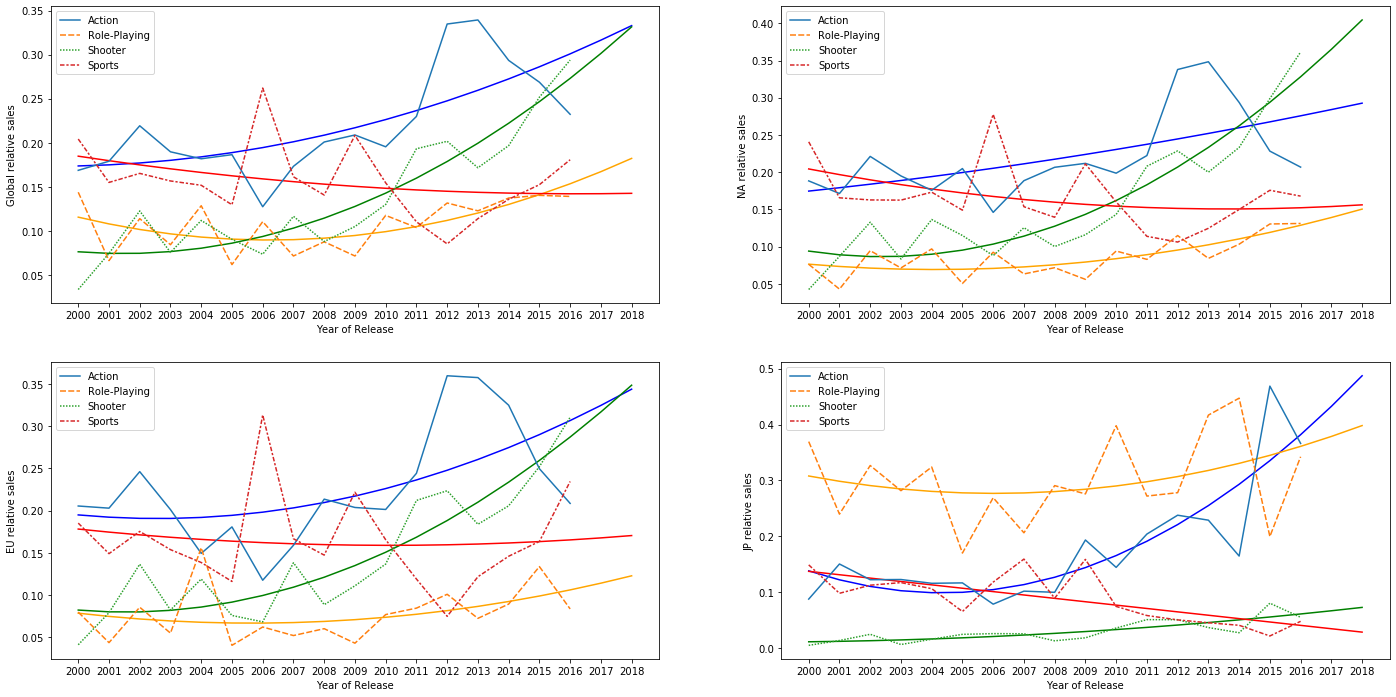

In [182]:
# We calculate the prediction for relative sales in 2018 and store them inside a Data Frame
# The array pred_res contains the results and will be used later to construct the Data Frame
pred_res = np.zeros((len(regions), len(genres)))

# The year we want to predict 20**
year = 18
x = np.arange(0,year+1,1)
# Determine the predicted values and output the results    
plt.figure(figsize=(12*2,12))

# Loop over the regions - Global, NA, EU, JP
for j, reg in enumerate(regions):
    
    plt.subplot(2,2,j+1)

    # Loop over the different genres
    for i,gen in enumerate(genres):

        # Negative prediction value Japan - Sports, use linear regression instead
        if (i==3 and j==3):
            pred_res[j][i] = lin_fun(theta_lin[j][i], year)
            plt.plot(x+2000, lin_fun(theta_lin[j][i], x), color=col[i]) 
        else:
            pred_res[j][i] = poly2_fun(theta_pol[j][i], year)
            plt.plot(x+2000, poly2_fun(theta_pol[j][i], x), color=col[i])

    sns.lineplot(data=genre_rel_arr[j])
    plt.ylabel('%s relative sales' %(reg))
    plt.xlabel('Year of Release')
    plt.xticks(x+2000)
plt.savefig('pred_rel_genre.pdf')


prediction = pd.DataFrame(pred_res, columns=genres, index=regions)
print(prediction)